In [33]:
def organize_demo_block_data(
    source_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
):
    """Organize Demo Block images using both normal and defect samples."""
    import os
    import shutil
    import random
    from pathlib import Path

    # Create directory structure
    os.makedirs(f"{output_dir}/train/normal", exist_ok=True)
    os.makedirs(f"{output_dir}/train/defect", exist_ok=True)
    os.makedirs(f"{output_dir}/validation/normal", exist_ok=True)
    os.makedirs(f"{output_dir}/validation/defect", exist_ok=True)
    os.makedirs(f"{output_dir}/test/normal", exist_ok=True)
    os.makedirs(f"{output_dir}/test/defect", exist_ok=True)

    # Process normal images
    normal_dir = os.path.join(source_dir, "good")
    normal_files = list(Path(normal_dir).glob("*.BMP"))
    if not normal_files:
        normal_files = list(Path(normal_dir).glob("*.bmp"))  # Try lowercase extension
    
    # Process defect images
    defect_dir = os.path.join(source_dir, "defect")
    defect_files = list(Path(defect_dir).glob("*.BMP"))
    if not defect_files:
        defect_files = list(Path(defect_dir).glob("*.bmp"))  # Try lowercase extension

    # Randomize order
    random.shuffle(normal_files)
    random.shuffle(defect_files)

    # Split normal data
    normal_count = len(normal_files)
    normal_train_end = int(normal_count * train_ratio)
    normal_val_end = normal_train_end + int(normal_count * val_ratio)

    # Split defect data
    defect_count = len(defect_files)
    defect_train_end = int(defect_count * train_ratio)
    defect_val_end = defect_train_end + int(defect_count * val_ratio)

    # Copy normal files
    for i, file_path in enumerate(normal_files):
        if i < normal_train_end:
            dest_dir = f"{output_dir}/train/normal"
        elif i < normal_val_end:
            dest_dir = f"{output_dir}/validation/normal"
        else:
            dest_dir = f"{output_dir}/test/normal"
        shutil.copy(file_path, f"{dest_dir}/{file_path.name}")
    
    # Copy defect files
    for i, file_path in enumerate(defect_files):
        if i < defect_train_end:
            dest_dir = f"{output_dir}/train/defect"
        elif i < defect_val_end:
            dest_dir = f"{output_dir}/validation/defect"
        else:
            dest_dir = f"{output_dir}/test/defect"
        shutil.copy(file_path, f"{dest_dir}/{file_path.name}")

    print(f"Organized {normal_count} normal images and {defect_count} defect images into train/validation/test splits")

# Usage
organize_demo_block_data("data/Demo Block", "defect_detection_dataset")

Organized 12 normal images and 10 defect images into train/validation/test splits


In [34]:
def generate_synthetic_defects(normal_dir, output_dir, num_defects_per_image=1):
    """Generate synthetic defects from normal images.
    
    Args:
        normal_dir: Directory containing normal images
        output_dir: Directory to save synthetic defects (should be 'defect_detection_dataset/train/defect')
        num_defects_per_image: Number of defect variants to generate per normal image
    """
    import cv2
    import numpy as np
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Get all images from normal directory
    normal_images = [f for f in os.listdir(normal_dir) if f.endswith(('.BMP', '.bmp', '.jpg', '.png'))]
    
    for img_file in normal_images:
        # Read the normal image
        img_path = os.path.join(normal_dir, img_file)
        img = cv2.imread(img_path)
        
        if img is None:
            print(f"Could not read image: {img_path}")
            continue
        
        base_name = os.path.splitext(img_file)[0]
        
        for i in range(num_defects_per_image):
            # Create a copy for modification
            defect_img = img.copy()
            
            # Choose a random defect type (1-4)
            defect_type = np.random.randint(1, 5)
            
            if defect_type == 1:
                # Add random scratches
                x1, y1 = np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0])
                x2, y2 = np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0])
                cv2.line(defect_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                
            elif defect_type == 2:
                # Add random spot/blob
                cx, cy = np.random.randint(0, img.shape[1]), np.random.randint(0, img.shape[0])
                radius = np.random.randint(5, 20)
                color = (0, 0, np.random.randint(150, 255))
                cv2.circle(defect_img, (cx, cy), radius, color, -1)
                
            elif defect_type == 3:
                # Add random noise in a region
                x, y = np.random.randint(0, img.shape[1] - 50), np.random.randint(0, img.shape[0] - 50)
                w, h = np.random.randint(30, 50), np.random.randint(30, 50)
                roi = defect_img[y:y+h, x:x+w]
                noise = np.random.randint(0, 50, roi.shape, dtype=np.uint8)
                roi = cv2.add(roi, noise)
                defect_img[y:y+h, x:x+w] = roi
                
            else:
                # Add a small missing part (black rectangle)
                x, y = np.random.randint(0, img.shape[1] - 40), np.random.randint(0, img.shape[0] - 40)
                w, h = np.random.randint(10, 40), np.random.randint(10, 40)
                cv2.rectangle(defect_img, (x, y), (x+w, y+h), (0, 0, 0), -1)
            
            # Save the defect image
            output_path = os.path.join(output_dir, f"{base_name}_defect_{i+1}.jpg")
            cv2.imwrite(output_path, defect_img)
            
    print(f"Generated {len(normal_images) * num_defects_per_image} synthetic defect images")

In [35]:
def build_anomaly_detection_model():
    """Build an enhanced autoencoder for anomaly detection when only normal samples are available."""
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, LeakyReLU
    from tensorflow.keras.models import Model
    
    # Input shape
    input_img = Input(shape=(224, 224, 3))
    
    # Encoder - improved with BatchNorm and LeakyReLU
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder - improved with BatchNorm and LeakyReLU
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [36]:
def train_and_evaluate_anomaly_detection(normal_data_dir, test_normal_dir=None, test_defect_dir=None, epochs=50, batch_size=32):
    """Train and evaluate an anomaly detection model when only normal samples are available.
    
    Args:
        normal_data_dir: Directory containing normal images for training
        test_normal_dir: Directory containing normal test images, if available
        test_defect_dir: Directory containing defect test images, if available
        epochs: Number of epochs to train
        batch_size: Batch size for training
    
    Returns:
        Tuple of (model, threshold) where threshold is the optimal value for anomaly detection
    """
    import os
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt
    from tensorflow.keras.callbacks import EarlyStopping
    
    print(f"Training anomaly detection model on normal samples from {normal_data_dir}")
    
    # Build the autoencoder model
    autoencoder = build_anomaly_detection_model()
    
    # Load normal images for training
    normal_images = []
    for img_file in os.listdir(normal_data_dir):
        if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
            img_path = os.path.join(normal_data_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                normal_images.append(img)
    
    # Convert to numpy array and normalize
    normal_images = np.array(normal_images).astype('float32') / 255.0
    print(f"Loaded {len(normal_images)} normal images for training")
    
    # Train the autoencoder
    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]
    
    history = autoencoder.fit(
        normal_images, normal_images,  # Same input and output for reconstruction
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,  # Use 20% for validation
        callbacks=callbacks,
        shuffle=True
    )
    
    # Plot training progress
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Autoencoder Training Loss')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.savefig('autoencoder_training.png')
    plt.show()
    
    # Calculate reconstruction errors on training data to set threshold
    reconstructions = autoencoder.predict(normal_images)
    train_errors = np.mean(np.square(normal_images - reconstructions), axis=(1, 2, 3))
    
    # Set threshold as the 95th percentile of errors on normal data
    threshold = np.percentile(train_errors, 95)
    print(f"Anomaly threshold set to: {threshold:.6f}")
    
    # Save the anomaly detection model
    autoencoder.save("trained_models/anomaly_detection_model.keras")
    
    # Save threshold
    import json
    with open("trained_models/anomaly_threshold.json", 'w') as f:
        json.dump({"threshold": float(threshold)}, f)
    
    # If test sets are available, evaluate the model
    if test_normal_dir and test_defect_dir and os.path.exists(test_normal_dir) and os.path.exists(test_defect_dir):
        # Load test normal images
        test_normal_images = []
        for img_file in os.listdir(test_normal_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
                img_path = os.path.join(test_normal_dir, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    test_normal_images.append(img)
        
        # Load test defect images
        test_defect_images = []
        for img_file in os.listdir(test_defect_dir):
            if img_file.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP')):
                img_path = os.path.join(test_defect_dir, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (224, 224))
                    test_defect_images.append(img)
        
        # Convert to numpy arrays and normalize
        test_normal_images = np.array(test_normal_images).astype('float32') / 255.0
        test_defect_images = np.array(test_defect_images).astype('float32') / 255.0
        
        # Calculate reconstruction errors
        normal_reconstructions = autoencoder.predict(test_normal_images)
        defect_reconstructions = autoencoder.predict(test_defect_images)
        
        normal_errors = np.mean(np.square(test_normal_images - normal_reconstructions), axis=(1, 2, 3))
        defect_errors = np.mean(np.square(test_defect_images - defect_reconstructions), axis=(1, 2, 3))
        
        # Calculate metrics
        tn = np.sum(normal_errors < threshold)
        fp = np.sum(normal_errors >= threshold)
        fn = np.sum(defect_errors < threshold)
        tp = np.sum(defect_errors >= threshold)
        
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print("\nAnomaly Detection Performance:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Visualize distribution of errors
        plt.figure(figsize=(10, 6))
        plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
        plt.hist(defect_errors, bins=50, alpha=0.5, label='Defect')
        plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6f})')
        plt.xlabel('Reconstruction Error (MSE)')
        plt.ylabel('Count')
        plt.title('Distribution of Reconstruction Errors')
        plt.legend()
        plt.savefig('error_distribution.png')
        plt.show()
        
        # Visualize some examples
        import random
        
        # Choose random samples to visualize
        normal_indices = random.sample(range(len(test_normal_images)), min(3, len(test_normal_images)))
        defect_indices = random.sample(range(len(test_defect_images)), min(3, len(test_defect_images)))
        
        plt.figure(figsize=(15, 10))
        
        # Plot normal examples
        for i, idx in enumerate(normal_indices):
            # Original image
            plt.subplot(len(normal_indices) + len(defect_indices), 3, i*3 + 1)
            plt.imshow(test_normal_images[idx])
            plt.title(f"Normal (Original)")
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(len(normal_indices) + len(defect_indices), 3, i*3 + 2)
            plt.imshow(normal_reconstructions[idx])
            plt.title(f"Reconstruction")
            plt.axis('off')
            
            # Difference
            plt.subplot(len(normal_indices) + len(defect_indices), 3, i*3 + 3)
            error_map = np.abs(test_normal_images[idx] - normal_reconstructions[idx])
            plt.imshow(error_map)
            plt.title(f"Error: {normal_errors[idx]:.6f}")
            plt.axis('off')
        
        # Plot defect examples
        for i, idx in enumerate(defect_indices):
            row_offset = len(normal_indices)
            # Original image
            plt.subplot(len(normal_indices) + len(defect_indices), 3, (row_offset + i)*3 + 1)
            plt.imshow(test_defect_images[idx])
            plt.title(f"Defect (Original)")
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(len(normal_indices) + len(defect_indices), 3, (row_offset + i)*3 + 2)
            plt.imshow(defect_reconstructions[idx])
            plt.title(f"Reconstruction")
            plt.axis('off')
            
            # Difference
            plt.subplot(len(normal_indices) + len(defect_indices), 3, (row_offset + i)*3 + 3)
            error_map = np.abs(test_defect_images[idx] - defect_reconstructions[idx])
            plt.imshow(error_map)
            plt.title(f"Error: {defect_errors[idx]:.6f}")
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('anomaly_examples.png')
        plt.show()
    
    return autoencoder, threshold

In [37]:
def save_model_for_app_compatibility(model, model_name="defect_detection_model"):
    """Save the model in formats compatible with the ABB Vision System app."""
    import os
    import json
    import datetime
    
    # Create models directory if it doesn't exist
    os.makedirs("trained_models", exist_ok=True)
    
    # 1. Save in both formats - legacy H5 for compatibility and new Keras format
    # Legacy format (keep for compatibility with existing code)
    model.save(f"trained_models/{model_name}.h5")
    # New recommended Keras format
    model.save(f"trained_models/{model_name}.keras")
    
    # 2. Save as TFLite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open(f"trained_models/{model_name}.tflite", 'wb') as f:
        f.write(tflite_model)
    
    # 3. Save class mapping
    class_mapping = {
        0: "normal",
        1: "defect"
    }
    with open(f"trained_models/class_mapping.json", 'w') as f:
        json.dump(class_mapping, f)
    
    # 4. Create a model info file for the app
    model_info = {
        "model_name": model_name,
        "input_shape": [224, 224, 3],
        "preprocessing": "normalize_to_0_1",
        "class_names": ["normal", "defect"],
        "date_trained": str(datetime.datetime.now()),
        "model_type": "binary_classification",
        "keras_format_path": f"trained_models/{model_name}.keras"  # Add reference to new format
    }
    with open(f"trained_models/{model_name}_info.json", 'w') as f:
        json.dump(model_info, f, indent=2)
    
    print(f"Model saved in multiple formats for app compatibility in 'trained_models/' directory")
    print(f"- Legacy H5 format: trained_models/{model_name}.h5")
    print(f"- New Keras format: trained_models/{model_name}.keras")

In [38]:
def visualize_model_predictions(model, test_dir, num_images=10, threshold=0.5):
    """Visualize model predictions on test images with confidence scores."""
    import random
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import numpy as np
    import os
    import cv2
    
    # Get test images from both normal and defect classes
    normal_dir = os.path.join(test_dir, 'normal')
    defect_dir = os.path.join(test_dir, 'defect')
    
    normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) 
                    if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    
    defect_images = [os.path.join(defect_dir, f) for f in os.listdir(defect_dir) 
                    if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    
    # Randomly select images
    selected_normals = random.sample(normal_images, min(num_images//2, len(normal_images)))
    selected_defects = random.sample(defect_images, min(num_images//2, len(defect_images)))
    
    selected_images = selected_normals + selected_defects
    random.shuffle(selected_images)
    
    plt.figure(figsize=(15, num_images*3))
    
    for i, img_path in enumerate(selected_images[:num_images]):
        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get true class from path
        true_class = "Normal" if "/normal/" in img_path else "Defect"
        
        # Preprocess for model
        img_resized = cv2.resize(img, (224, 224))
        img_array = img_resized.astype('float32') / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Get prediction
        prediction = model.predict(img_array)[0][0]
        predicted_class = "Defect" if prediction > threshold else "Normal"
        
        # Create plot
        plt.subplot(num_images, 2, i*2+1)
        plt.imshow(img)
        plt.title(f"Original ({true_class})")
        plt.axis('off')
        
        plt.subplot(num_images, 2, i*2+2)
        plt.imshow(img)
        
        # Add border color based on correct/incorrect prediction
        is_correct = (true_class == predicted_class)
        border_color = 'green' if is_correct else 'red'
        
        # Add rectangle border
        plt.gca().add_patch(
            patches.Rectangle((0, 0), img.shape[1], img.shape[0],
                             linewidth=5, edgecolor=border_color, facecolor='none')
        )
        
        plt.title(f"Pred: {predicted_class} ({prediction:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()

In [39]:
def evaluate_anomaly_detection(model, test_normal_dir, test_defect_dir):
    """Evaluate anomaly detection performance with appropriate metrics."""
    from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import cv2
    
    # Load normal and defect test images
    normal_images = [os.path.join(test_normal_dir, f) for f in os.listdir(test_normal_dir) 
                    if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    
    defect_images = [os.path.join(test_defect_dir, f) for f in os.listdir(test_defect_dir) 
                    if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.BMP'))]
    
    # Prepare data
    all_images = normal_images + defect_images
    true_labels = [0] * len(normal_images) + [1] * len(defect_images)  # 0 for normal, 1 for defect
    
    # Get predictions
    predictions = []
    for img_path in all_images:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        
        pred = model.predict(img)[0][0]
        predictions.append(pred)
    
    # Convert to numpy arrays
    y_true = np.array(true_labels)
    y_scores = np.array(predictions)
    
    # Calculate Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)
    
    # Calculate ROC curve
    fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Find optimal threshold using F1 score
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot Precision-Recall curve
    ax1.step(recall, precision, color='b', alpha=0.2, where='post')
    ax1.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlim([0.0, 1.0])
    ax1.set_title(f'Precision-Recall curve: AP={average_precision:0.2f}')
    ax1.grid(True)
    
    # Plot ROC curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('anomaly_detection_evaluation.png')
    plt.show()
    
    # Print results
    print(f"Average Precision (AP): {average_precision:.4f}")
    print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    
    # Confusion matrix at optimal threshold
    y_pred = (y_scores >= optimal_threshold).astype(int)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    
    print("\nConfusion Matrix at Optimal Threshold:")
    print(f"True Negative: {tn}, False Positive: {fp}")
    print(f"False Negative: {fn}, True Positive: {tp}")
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision_score = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_score = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision_score * recall_score) / (precision_score + recall_score) if (precision_score + recall_score) > 0 else 0
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision_score:.4f}")
    print(f"Recall: {recall_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return {
        'average_precision': average_precision,
        'roc_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1
    }

In [40]:
def create_defect_detection_model_class():
    """Create a DefectDetectionModel class file for app compatibility."""
    import os
    
    # Create models directory if it doesn't exist
    os.makedirs("abbvisionsystem/models", exist_ok=True)
    
    # Define the model class code
    code = '''"""Defect detection model implementation for industrial inspection."""

import os
import json
import logging
import numpy as np
import tensorflow as tf
import cv2
from abbvisionsystem.models.base_model import BaseModel

logger = logging.getLogger(__name__)


class DefectDetectionModel(BaseModel):
    """Model for industrial defect detection/classification."""

    def __init__(self, model_path="trained_models/final_defect_model.h5", class_mapping_path="trained_models/class_mapping.json"):
        super().__init__(model_path)
        self.class_mapping_path = class_mapping_path
        self.model = None
        self.class_mapping = {}
        self.model_info_path = os.path.join(
            os.path.dirname(model_path),
            f"{os.path.splitext(os.path.basename(model_path))[0]}_info.json",
        )
        
        # Default categories (will be overridden by class_mapping if available)
        self.categories = {
            0: {"name": "Normal", "id": 0},
            1: {"name": "Defect", "id": 1},
        }
        
    def load(self):
        """Load the defect detection model supporting both .h5 and .keras formats."""
        try:
            # First check if model_info.json exists and contains keras_format_path
            keras_model_path = None
            if os.path.exists(self.model_info_path):
                try:
                    with open(self.model_info_path, 'r') as f:
                        model_info = json.load(f)
                        if "keras_format_path" in model_info:
                            keras_model_path = model_info["keras_format_path"]
                            logger.info(f"Found keras model path in info file: {keras_model_path}")
                except Exception as e:
                    logger.warning(f"Could not parse model info file: {str(e)}")
            
            # Try loading model in order of preference: 
            # 1. keras_format_path from model_info if available
            # 2. original path with .keras extension
            # 3. original h5 path
            model_loaded = False
            
            # Try the keras path from model_info first
            if keras_model_path and os.path.exists(keras_model_path):
                try:
                    logger.info(f"Attempting to load model from keras path: {keras_model_path}")
                    self.model = tf.keras.models.load_model(keras_model_path)
                    model_loaded = True
                    logger.info(f"Successfully loaded model from: {keras_model_path}")
                except Exception as e:
                    logger.warning(f"Failed to load keras model from {keras_model_path}: {str(e)}")
            
            # Try with .keras extension if original path has .h5
            if not model_loaded and self.model_path.endswith('.h5'):
                keras_path = self.model_path.replace('.h5', '.keras')
                if os.path.exists(keras_path):
                    try:
                        logger.info(f"Attempting to load model from: {keras_path}")
                        self.model = tf.keras.models.load_model(keras_path)
                        model_loaded = True
                        logger.info(f"Successfully loaded model from: {keras_path}")
                    except Exception as e:
                        logger.warning(f"Failed to load keras model from {keras_path}: {str(e)}")
            
            # Fall back to original path
            if not model_loaded:
                if not os.path.exists(self.model_path):
                    logger.error(f"Model file not found: {self.model_path}")
                    return False
                
                logger.info(f"Attempting to load model from original path: {self.model_path}")
                self.model = tf.keras.models.load_model(self.model_path)
                logger.info(f"Successfully loaded model from: {self.model_path}")

            # Load class mapping if available
            if os.path.exists(self.class_mapping_path):
                with open(self.class_mapping_path, 'r') as f:
                    self.class_mapping = json.load(f)
                
                # Update categories
                for class_id, class_name in self.class_mapping.items():
                    self.categories[int(class_id)] = {"name": class_name, "id": int(class_id)}
            
            self.loaded = True
            return True

        except Exception as e:
            logger.error(f"Failed to load model: {str(e)}")
            return False

    def predict(self, image):
        """Run prediction with the defect detection model."""
        if not self.loaded:
            logger.warning("Model not loaded. Call load() first.")
            return None

        try:
            # Resize image to model's expected input size
            img = cv2.resize(image, (224, 224))
            
            # Preprocess image - normalize to [0,1]
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=0)
            
            # Make prediction
            predictions = self.model.predict(img)
            
            # For binary classification
            score = float(predictions[0][0])
            class_id = 1 if score > 0.5 else 0
            
            # For compatibility with the TACO model return format
            # We're creating a pseudo detection with a single box covering most of the image
            # This allows the app to display the result using the same visualization logic
            return {
                "boxes": np.array([[0.1, 0.1, 0.9, 0.9]]),  # Single box covering most of image
                "scores": np.array([score if class_id == 1 else 1.0 - score]),  # Confidence score
                "classes": np.array([class_id]),  # Class ID (0=normal, 1=defect)
                "num_detections": 1,  # Only one detection for the whole image
            }

        except Exception as e:
            logger.error(f"Prediction error: {str(e)}")
            return None

    def visualize_detections(self, image, detections, threshold=0.5):
        """Draw classification results on image."""
        image_with_result = image.copy()
        height, width, _ = image.shape

        # Only proceed if we have detections
        if detections["num_detections"] > 0:
            # Get class and score
            class_id = detections["classes"][0]
            score = detections["scores"][0]
            
            if score > threshold:
                # Draw border color based on class
                border_color = (0, 0, 255) if class_id == 1 else (0, 255, 0)  # Red for defect, Green for normal
                border_thickness = 10
                
                # Draw colored border around the entire image
                cv2.rectangle(
                    image_with_result, 
                    (border_thickness, border_thickness), 
                    (width - border_thickness, height - border_thickness), 
                    border_color, 
                    border_thickness
                )
                
                # Get class name
                class_name = self.categories.get(class_id, {}).get("name", f"Class {class_id}")
                
                # Add label with large font at the top
                label = f"{class_name}: {score:.2f}"
                font_scale = 1.5
                font_thickness = 2
                
                # Get text size for centering
                text_size = cv2.getTextSize(
                    label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness
                )[0]
                
                # Position text in the top center
                text_x = (width - text_size[0]) // 2
                text_y = text_size[1] + 20
                
                # Draw text with background
                cv2.putText(
                    image_with_result,
                    label,
                    (text_x, text_y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    border_color,
                    font_thickness,
                )

        return image_with_result
'''
    
    # Write the code to the file
    with open("abbvisionsystem/models/defect_detection_model.py", 'w') as f:
        f.write(code)
    
    print("DefectDetectionModel class created at abbvisionsystem/models/defect_detection_model.py")

In [41]:
def visualize_augmentations(image_path=None, n_samples=5):
    """Visualize augmentation results to verify quality."""
    import tensorflow as tf
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import cv2
    
    # Handle different TensorFlow/Keras versions
    try:
        # Try the newer keras standalone package first
        from keras.preprocessing.image import ImageDataGenerator
    except ImportError:
        try:
            # Try the older tensorflow.keras path
            from tensorflow.keras.preprocessing.image import ImageDataGenerator
        except ImportError:
            # Final fallback
            print("ImageDataGenerator not found. Please check your keras and tensorflow installation.")
            return None
    
    # Get a sample image if path not provided
    if image_path is None:
        # Get a random normal image
        normal_dir = 'defect_detection_dataset/train/normal'
        image_files = [f for f in os.listdir(normal_dir) if f.endswith(('.BMP', '.bmp', '.jpg', '.png'))]
        if not image_files:
            print("No images found in training directory")
            return
        image_path = os.path.join(normal_dir, image_files[0])
    
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Define the target size
    IMAGE_SIZE = (224, 224)
    
    # Resize to model input size
    img_resized = cv2.resize(img, IMAGE_SIZE)
    
    # Create data generator with augmentations
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )
    
    # Generate augmented images
    aug_images = []
    img_array = np.expand_dims(img_resized, axis=0)
    aug_iter = datagen.flow(img_array, batch_size=1)
    
    for i in range(n_samples):
        aug_images.append(next(aug_iter)[0].astype('uint8'))  # Using next() instead of .next()
    
    # Plot the images
    plt.figure(figsize=(15, 4))
    
    # Original image
    plt.subplot(1, n_samples+1, 1)
    plt.imshow(img_resized)
    plt.title('Original')
    plt.axis('off')
    
    # Augmented images
    for i in range(n_samples):
        plt.subplot(1, n_samples+1, i+2)
        plt.imshow(aug_images[i])
        plt.title(f'Aug {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('augmentation_visualization.png')
    plt.show()
    
    return aug_images

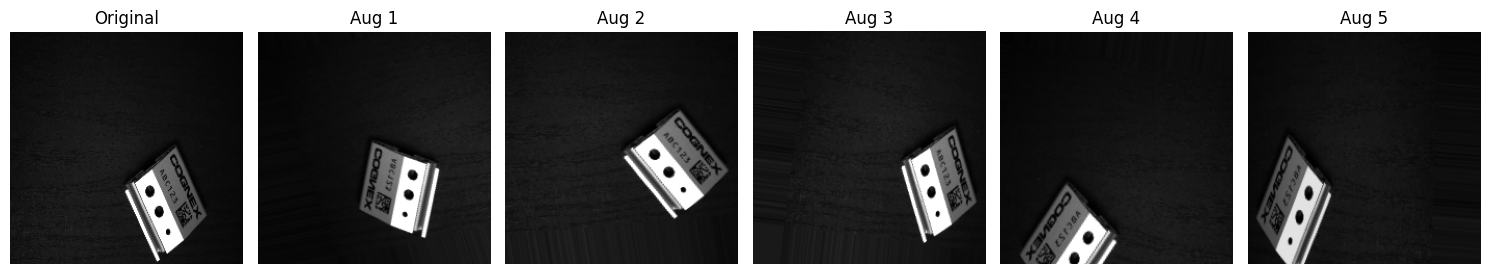

[array([[[ 3,  3,  3],
         [ 3,  3,  3],
         [ 3,  3,  3],
         ...,
         [13, 13, 13],
         [13, 13, 13],
         [13, 13, 13]],
 
        [[ 3,  3,  3],
         [ 3,  3,  3],
         [ 3,  3,  3],
         ...,
         [13, 13, 13],
         [13, 13, 13],
         [13, 13, 13]],
 
        [[ 3,  3,  3],
         [ 3,  3,  3],
         [ 3,  3,  3],
         ...,
         [12, 12, 12],
         [12, 12, 12],
         [15, 15, 15]],
 
        ...,
 
        [[ 7,  7,  7],
         [ 7,  7,  7],
         [ 7,  7,  7],
         ...,
         [26, 26, 26],
         [28, 28, 28],
         [28, 28, 28]],
 
        [[ 8,  8,  8],
         [ 8,  8,  8],
         [ 8,  8,  8],
         ...,
         [25, 25, 25],
         [26, 26, 26],
         [28, 28, 28]],
 
        [[ 7,  7,  7],
         [ 7,  7,  7],
         [ 7,  7,  7],
         ...,
         [25, 25, 25],
         [26, 26, 26],
         [28, 28, 28]]], dtype=uint8),
 array([[[13, 13, 13],
         [12, 12, 1

In [42]:
visualize_augmentations(n_samples=5)

In [43]:
def create_improved_model(input_shape=(224, 224, 3), use_pretrained=True):
    """Create an improved model with better architecture for defect detection."""
    from tensorflow.keras.applications import ResNet50V2, MobileNetV2
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization

    # Option 1: ResNet50V2 (more accurate but larger)
    if use_pretrained:
        base_model = ResNet50V2(input_shape=input_shape, include_top=False, weights='imagenet')
    else:
        base_model = ResNet50V2(input_shape=input_shape, include_top=False, weights=None)
    
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification (normal vs. defect)
    ])
    
    # Freeze the base model layers
    base_model.trainable = False
    
    return model

In [44]:
# 2. Build and train the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2, EfficientNetB3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
MODEL_NAME = "final_defect_model"

# Define data generators with enhanced augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Added brightness variation
    fill_mode='nearest',
    # Add slight color adjustments for more robust model
    channel_shift_range=10.0  
)

validation_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    'defect_detection_dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    'defect_detection_dataset/validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Create improved model architecture
model = Sequential([
    # Use ResNet50V2 instead of ResNet50 for better performance
    ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet'),
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Add BatchNorm after pooling
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Reduced dropout rate for second layer
    Dense(1, activation='sigmoid')
])

# Fine-tuning strategy: Unfreeze some top layers for better adaptation
base_model = model.layers[0]
base_model.trainable = True

# Freeze early layers, unfreeze later layers
for layer in base_model.layers[:-30]:  # Freeze first ~170 layers (out of ~200)
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate for fine-tuning

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]  # Added precision and recall metrics
)

# Calculate class weights for imbalanced data
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print(f"Class weights to handle imbalance: {class_weight_dict}")

# Define callbacks with improved parameters
callbacks = [
    EarlyStopping(
        patience=15,  # Increased patience
        restore_best_weights=True,
        monitor='val_loss'  # Monitor validation loss instead of accuracy
    ),
    ReduceLROnPlateau(
        factor=0.2,  # More gradual reduction
        patience=5, 
        min_lr=1e-6,  # Set a minimum learning rate
        verbose=1
    ),
    ModelCheckpoint(
        f'trained_models/{MODEL_NAME}_checkpoint.h5', 
        save_best_only=True,
        monitor='val_loss'  # Save based on validation loss
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Using class weights
    verbose=1
)

Found 15 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Class weights to handle imbalance: {0: np.float64(1.0714285714285714), 1: np.float64(0.9375)}
Epoch 1/50


/Users/ducle/Library/Caches/pypoetry/virtualenvs/abbvisionsystem-kCkDzoyO-py3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4000 - loss: 0.9574 - precision_2: 0.4444 - recall_2: 0.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4000 - loss: 0.9574 - precision_2: 0.4444 - recall_2: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.7684 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.4000 - loss: 1.0388 - precision_2: 0.4286 - recall_2: 0.3750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step - accuracy: 0.4000 - loss: 1.0388 - precision_2: 0.4286 - recall_2: 0.3750 - val_accuracy: 0.5000 - val_loss: 0.7636 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.3333 - loss: 1.0812 - precision_2: 0.3333 - recall_2: 0.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 869ms/step - accuracy: 0.3333 - loss: 1.0812 - precision_2: 0.3333 - recall_2: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.7629 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.4000 - loss: 1.0488 - precision_2: 0.4000 - recall_2: 0.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4000 - loss: 1.0488 - precision_2: 0.4000 - recall_2: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.7610 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step - accuracy: 0.4000 - loss: 0.8610 - precision_2: 0.4286 - recall_2: 0.3750 - val_accuracy: 0.5000 - val_loss: 0.7619 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6000 - loss: 0.7577 - precision_2: 0.6667 - recall_2: 0.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6000 - loss: 0.7577 - precision_2: 0.6667 - recall_2: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.7605 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.6667 - loss: 0.5799 - precision_2: 0.7143 - recall_2: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step - accuracy: 0.6667 - loss: 0.5799 - precision_2: 0.7143 - recall_2: 0.6250 - val_accuracy: 0.5000 - val_loss: 0.7417 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5333 - loss: 0.7390 - precision_2: 0.6000 - recall_2: 0.3750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step - accuracy: 0.5333 - loss: 0.7390 - precision_2: 0.6000 - recall_2: 0.3750 - val_accuracy: 0.5000 - val_loss: 0.7251 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4667 - loss: 1.1021 - precision_2: 0.5000 - recall_2: 0.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - accuracy: 0.4667 - loss: 1.1021 - precision_2: 0.5000 - recall_2: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.7097 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.5333 - loss: 1.0577 - precision_2: 0.6667 - recall_2: 0.2500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step - accuracy: 0.5333 - loss: 1.0577 - precision_2: 0.6667 - recall_2: 0.2500 - val_accuracy: 0.5000 - val_loss: 0.6993 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.8667 - loss: 0.3690 - precision_2: 1.0000 - recall_2: 0.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step - accuracy: 0.8667 - loss: 0.3690 - precision_2: 1.0000 - recall_2: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.6841 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8667 - loss: 0.3882 - precision_2: 0.8750 - recall_2: 0.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - accuracy: 0.8667 - loss: 0.3882 - precision_2: 0.8750 - recall_2: 0.8750 - val_accuracy: 0.5000 - val_loss: 0.6741 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8667 - loss: 0.3554 - precision_2: 0.8750 - recall_2: 0.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step - accuracy: 0.8667 - loss: 0.3554 - precision_2: 0.8750 - recall_2: 0.8750 - val_accuracy: 0.5000 - val_loss: 0.6639 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6000 - loss: 0.8637 - precision_2: 0.6250 - recall_2: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step - accuracy: 0.6000 - loss: 0.8637 - precision_2: 0.6250 - recall_2: 0.6250 - val_accuracy: 0.5000 - val_loss: 0.6478 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.7333 - loss: 0.4542 - precision_2: 0.8333 - recall_2: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 870ms/step - accuracy: 0.7333 - loss: 0.4542 - precision_2: 0.8333 - recall_2: 0.6250 - val_accuracy: 0.5000 - val_loss: 0.6299 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.6000 - loss: 0.7195 - precision_2: 0.6667 - recall_2: 0.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 850ms/step - accuracy: 0.6000 - loss: 0.7195 - precision_2: 0.6667 - recall_2: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.6072 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 17/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.4667 - loss: 0.6995 - precision_2: 0.5000 - recall_2: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 882ms/step - accuracy: 0.4667 - loss: 0.6995 - precision_2: 0.5000 - recall_2: 0.6250 - val_accuracy: 0.5000 - val_loss: 0.5960 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 18/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 0.5333 - loss: 0.7173 - precision_2: 0.5714 - recall_2: 0.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step - accuracy: 0.5333 - loss: 0.7173 - precision_2: 0.5714 - recall_2: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.5805 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 19/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.8667 - loss: 0.3134 - precision_2: 1.0000 - recall_2: 0.7500

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step - accuracy: 0.8667 - loss: 0.3134 - precision_2: 1.0000 - recall_2: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.5668 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 20/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.6000 - loss: 0.7137 - precision_2: 0.6667 - recall_2: 0.5000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step - accuracy: 0.6000 - loss: 0.7137 - precision_2: 0.6667 - recall_2: 0.5000 - val_accuracy: 0.5000 - val_loss: 0.5548 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 21/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.9333 - loss: 0.3503 - precision_2: 1.0000 - recall_2: 0.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step - accuracy: 0.9333 - loss: 0.3503 - precision_2: 1.0000 - recall_2: 0.8750 - val_accuracy: 0.5000 - val_loss: 0.5488 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 22/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 589ms/step - accuracy: 0.7333 - loss: 0.5160 - precision_2: 0.8333 - recall_2: 0.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step - accuracy: 0.7333 - loss: 0.5160 - precision_2: 0.8333 - recall_2: 0.6250 - val_accuracy: 0.5000 - val_loss: 0.5429 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 23/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.8667 - loss: 0.2868 - precision_2: 0.8750 - recall_2: 0.8750

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step - accuracy: 0.8667 - loss: 0.2868 - precision_2: 0.8750 - recall_2: 0.8750 - val_accuracy: 0.5000 - val_loss: 0.5420 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 24/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9333 - loss: 0.2307 - precision_2: 0.8889 - recall_2: 1.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 868ms/step - accuracy: 0.9333 - loss: 0.2307 - precision_2: 0.8889 - recall_2: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.5419 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 25/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - accuracy: 0.8667 - loss: 0.2668 - precision_2: 1.0000 - recall_2: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.5439 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 26/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step - accuracy: 0.8667 - loss: 0.4462 - precision_2: 0.8750 - recall_2: 0.8750 - val_accuracy: 0.5000 - val_loss: 0.5471 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 27/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - accuracy: 0.8000 - loss: 0.4032 - precision_2: 0.8571 - recall_2: 0.7500 - val_accuracy: 0.5000 - val_loss: 0.5569 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04


Found 5 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4000 - loss: 0.8213 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Test accuracy: 0.4000
Test loss: 0.8213
Test precision: 0.0000
Test recall: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.40      1.00      0.57         2
      Defect       0.00      0.00      0.00         3

    accuracy                           0.40         5
   macro avg       0.20      0.50      0.29         5
weighted avg       0.16      0.40      0.23         5


Confusion Matrix:
[[2 0]
 [3 0]]


/Users/ducle/Library/Caches/pypoetry/virtualenvs/abbvisionsystem-kCkDzoyO-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ducle/Library/Caches/pypoetry/virtualenvs/abbvisionsystem-kCkDzoyO-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ducle/Library/Caches/pypoetry/virtualenvs/abbvisionsystem-kCkDzoyO-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

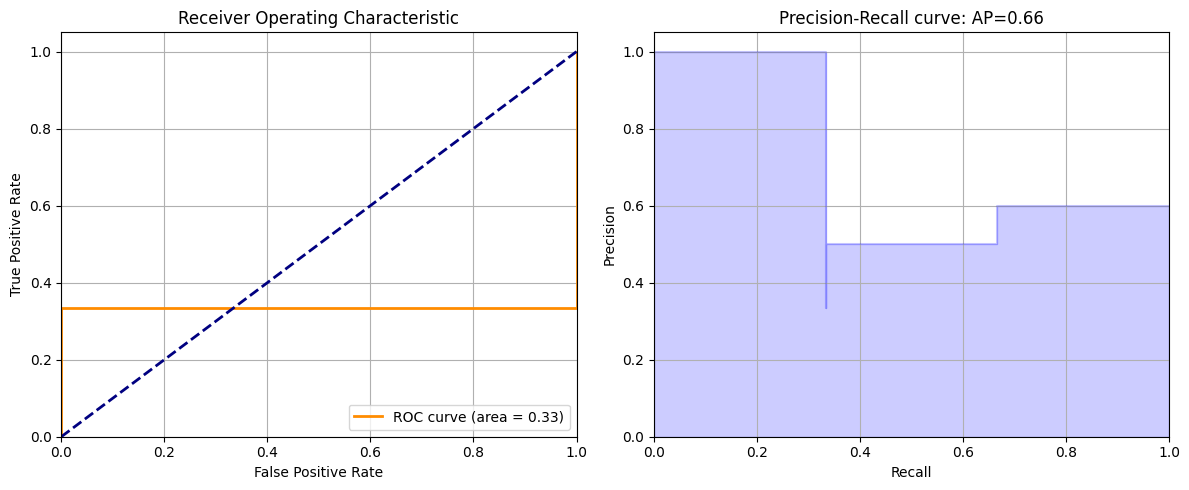

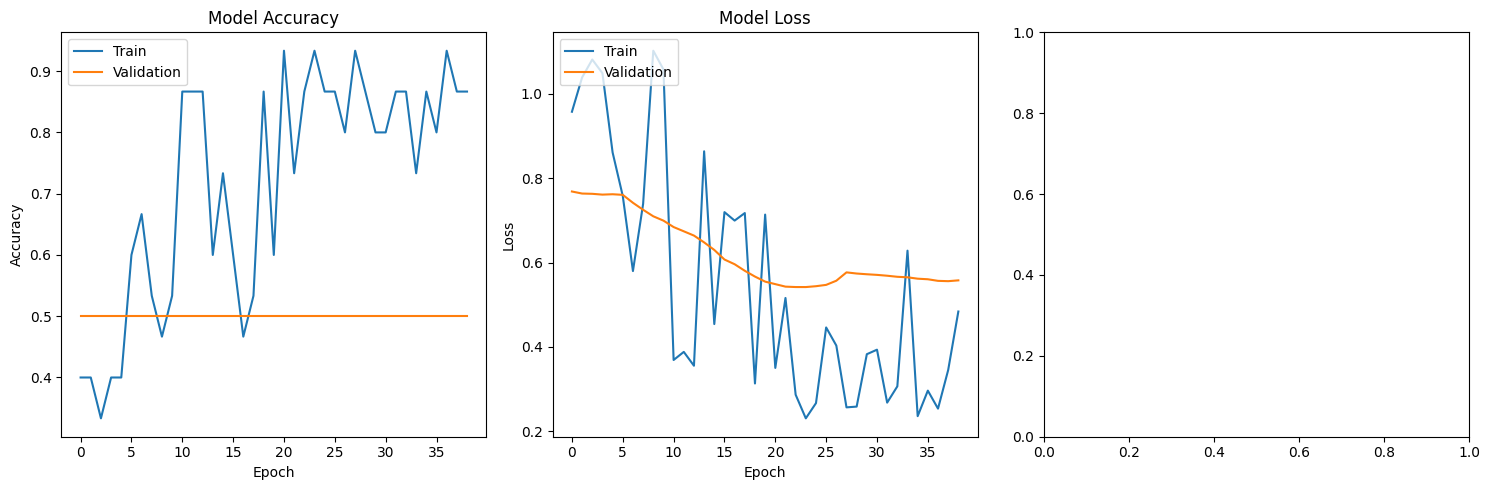

INFO:tensorflow:Assets written to: /var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx/assets


INFO:tensorflow:Assets written to: /var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx/assets


Saved artifact at '/var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_590')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  12988938960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988938384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988937616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988927056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988938000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988939152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988935504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988933968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988928016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12988928592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  129889

W0000 00:00:1747030156.754362  500221 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747030156.754376  500221 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-05-12 13:09:16.754534: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx
2025-05-12 13:09:16.761626: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-05-12 13:09:16.761642: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx
2025-05-12 13:09:16.860784: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-05-12 13:09:17.461256: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/8w/rnt4yvg55s123wgbg_0r__cw0000gn/T/tmpa4e4yhzx
2025-05-12 13:09:17.617677: I tensorflow/cc/saved_model/loader.cc:

Model saved in multiple formats for app compatibility in 'trained_models/' directory
- Legacy H5 format: trained_models/final_defect_model.h5
- New Keras format: trained_models/final_defect_model.keras
DefectDetectionModel class created at abbvisionsystem/models/defect_detection_model.py
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


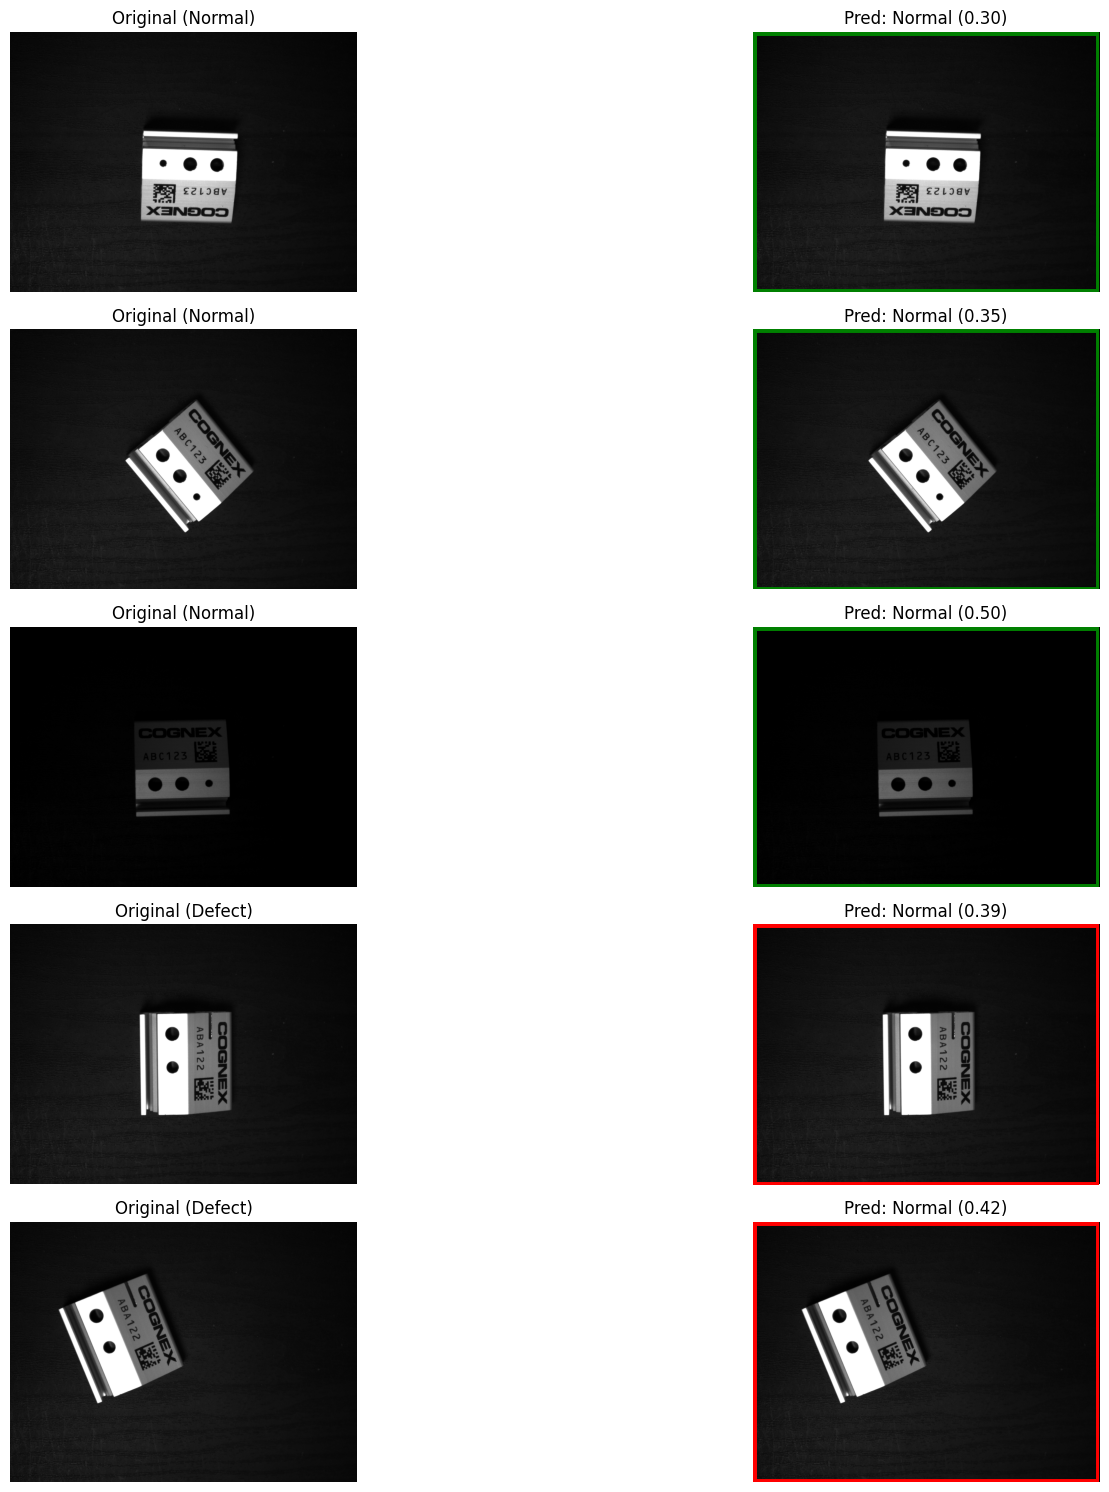


Final Checklist:
✓ Model trained and evaluated
✓ Model saved as trained_models/final_defect_model.h5
✓ Class mapping saved as trained_models/class_mapping.json
✓ DefectDetectionModel class created
✓ Model is compatible with app.py


In [45]:
# 3. Evaluate the model
import datetime
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Prepare test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'defect_detection_dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Evaluate model
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test precision: {test_precision:.4f}")
print(f"Test recall: {test_recall:.4f}")

# Get predictions
test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

# Print classification report
print("\nClassification Report:")
target_names = ['Normal', 'Defect']
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Print confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Plot ROC curve and PR curve
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)

# Precision-Recall curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
avg_precision = np.mean(precision)
plt.title(f'Precision-Recall curve: AP={avg_precision:.2f}')
plt.grid(True)

plt.tight_layout()
plt.savefig('model_performance_curves.png')
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
if 'precision' in history.history:
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# 4. Save the model for app compatibility
save_model_for_app_compatibility(model, MODEL_NAME)

# 5. Create the DefectDetectionModel class if it doesn't exist
create_defect_detection_model_class()

# 6. Visualize some model predictions
visualize_model_predictions(model, 'defect_detection_dataset/test', num_images=6)

# 7. Final step: Check if everything is ready for the app
print("\nFinal Checklist:")
print(f"✓ Model trained and evaluated")
print(f"✓ Model saved as trained_models/{MODEL_NAME}.h5")
print(f"✓ Class mapping saved as trained_models/class_mapping.json")
print(f"✓ DefectDetectionModel class created")
print(f"✓ Model is compatible with app.py")

In [46]:
# # 8. Train anomaly detection model for future use if defect samples become unavailable
print("\nPreparing for future scenarios without defect samples...")
print("This will train an anomaly detection model using only normal samples")
print("This model can be used if new defect types appear without labeled examples")

import os

# Check if user wants to train the anomaly detection model
user_input = input("Train anomaly detection model for future use? (y/n): ")

if user_input.lower() == 'y':
    # Train anomaly detection model using only normal samples
    autoencoder, threshold = train_and_evaluate_anomaly_detection(
        normal_data_dir='defect_detection_dataset/train/normal',
        test_normal_dir='defect_detection_dataset/test/normal',
        test_defect_dir='defect_detection_dataset/test/defect',
        epochs=50,
        batch_size=32
    )
    
    print("\nAnomaly Detection Model Summary:")
    print(f"- Model saved as: trained_models/anomaly_detection_model.keras")
    print(f"- Threshold saved in: trained_models/anomaly_threshold.json")
    print(f"- Threshold value: {threshold:.6f}")
    print("\nHow to use this model:")
    print("1. Load the model: model = tf.keras.models.load_model('trained_models/anomaly_detection_model.keras')")
    print("2. For a new image, calculate reconstruction error")
    print("3. If error > threshold, classify as defect")
else:
    print("Skipping anomaly detection model training.")


Preparing for future scenarios without defect samples...
This will train an anomaly detection model using only normal samples
This model can be used if new defect types appear without labeled examples
Skipping anomaly detection model training.
